# Topic 2: Recommendation System
### Demo: Underthesea, Gemsim, Cosin Similarity

In [1]:
!pip install gensim
!pip install pyvi
# !pip install underthesea

  Using cached pyvi-0.1.1-py2.py3-none-any.whl.metadata (2.5 kB)
  Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl.metadata (4.9 kB)
  Using cached python_crfsuite-0.9.11-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.3 kB)
Using cached pyvi-0.1.1-py2.py3-none-any.whl (8.5 MB)
Using cached sklearn_crfsuite-0.5.0-py2.py3-none-any.whl (10 kB)
Using cached python_crfsuite-0.9.11-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.3 MB)


In [2]:
# Note: Có thể tùy chọn các thư viện xử lý tiếng Việt

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
# from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re
from pyvi.ViTokenizer import tokenize

In [4]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/MyDrive/LDS0/Khoa_306/Project_2_RecommendationSytem_Agoda/demo'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS0/Khoa_306/Project_2_RecommendationSytem_Agoda/demo


In [5]:
STOP_WORD_FILE = 'files/vietnamese-stopwords.txt'

In [6]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

In [7]:
# Dữ liệu thử nghiệm
df= pd.read_csv('hotel_info_temp.csv')

In [8]:
# Tạo nội dung tổng hợp
# Lựa chọn các thông tin cần thiết để đưa vào phần content (giúp đề xuất nội dung)
# Có thể 1 cột hoặc nhiều cột thông tin
# ví dụ ở đây là chọn 1 cột, và chỉ lấy 200 từ đầu tiên trong phần mô tả (dễ quan sát khi làm demo)
df['Content'] = df['Hotel_Description'].apply(lambda x: ' '.join(x.split()[:200]))

In [9]:
df.head()

,Hotel_ID,Hotel_Name,Hotel_Description,Content
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,1_2,ALPHA BIRD NHA TRANG,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,1_3,Khách sạn Aaron (Aaron Hotel),Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,1_4,Panorama Star Beach Nha Trang,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [10]:
# word_tokenize
df["Content_wt"]=df["Content"].apply(lambda x: tokenize(x))

In [11]:
df[["Content", "Content_wt"]].head(2)

,Content,Content_wt
0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách_sạn Mường_Thanh_Luxury Nha_Trang - Nơi l...
1,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA TRANG - Khách_sạn 4.0 sao tại N...


# Gemsim
- https://pypi.org/project/gensim/
-Là một thư viện Python chuyên xác định sự tương tự về ngữ nghĩa giữa hai tài liệu thông qua mô hình không gian vector và bộ công cụ mô hình hóa chủ đề.
- Có thể xử lý kho dữ liệu văn bản lớn với sự trợ giúp của việc truyền dữ liệu hiệu quả và các thuật toán tăng cường
- Tốc độ xử lý và tối ưu hóa việc sử dụng bộ nhớ tốt
- Tuy nhiên, Gensim có ít tùy chọn tùy biến cho các function
#### Tham khảo:
- link https://www.tutorialspoint.com/gensim/index.htm
- link https://www.machinelearningplus.com/nlp/gensim-tutorial/

In [12]:
# Tokenize(split) the sentences into words
content_gem = [[text for text in x.split()] for x in df.Content_wt]

In [13]:
len(content_gem)

15

In [14]:
content_gem[:1]

[['Khách_sạn',
  'Mường_Thanh_Luxury',
  'Nha_Trang',
  '-',
  'Nơi',
  'lưu_trú',
  'tuyệt_vời',
  'tại',
  'Nha_Trang',
  'Khách_sạn',
  'Mường_Thanh_Luxury',
  'Nha_Trang',
  'nằm',
  'ở',
  'trung_tâm',
  'thành_phố',
  'Nha_Trang',
  ',',
  'Việt_Nam',
  ',',
  'là',
  'một',
  'khách_sạn',
  '5',
  'sao',
  'đẳng_cấp',
  '.',
  'Với',
  'vị_trí',
  'thuận_lợi',
  ',',
  'khách_sạn',
  'này',
  'chỉ',
  'cách',
  'trung_tâm',
  'thành_phố',
  '0.2',
  'km',
  'và',
  'cách',
  'sân_bay',
  'khoảng',
  '39',
  'phút',
  'đi',
  'xe',
  '.',
  'Khách_sạn',
  'Mường_Thanh_Luxury',
  'Nha_Trang',
  'được',
  'xây_dựng',
  'vào',
  'năm',
  '2014',
  'và',
  'hiện',
  'có',
  'tổng_cộng',
  '458',
  'phòng',
  '.',
  'Với',
  'số_lượng',
  'phòng',
  'lớn',
  'như_vậy',
  ',',
  'khách_sạn',
  'này',
  'đảm_bảo',
  'sẽ',
  'đáp_ứng',
  'được',
  'nhu_cầu',
  'lưu_trú',
  'của',
  'du_khách',
  'một_cách',
  'thoải_mái',
  'và',
  'tiện_nghi',
  '.',
  'Thời_gian',
  'nhận',
  'phòng',


In [15]:
import re

In [16]:
# Tiền xử lý dữ liệu
content_gem_re = [[re.sub('[0-9]+','', e) for e in text] for text in content_gem] # xem xét có cần bỏ các con số hay không
content_gem_re = [[t.lower() for t in text if not t in ['', ' ', ',', '.', '...', '-',':', ';', '?', '%', '(', ')', '+', '/', "'", '&']] for text in  content_gem_re] # kiểm tra nội dung và đưa vào các ký tự đặc biệt
content_gem_re = [[t for t in text if not t in stop_words] for text in content_gem_re] # stopword
# Thực hiện các tiền xử lý khác...
# Nên viết phần tiền xử lý này vào function để có thể tái sử dụng khi cần

In [17]:
content_gem_re[:1]
# Có thể đưa content_gem_re này thành 1 cột của df để không mất công xử lý nhiều lần

[['khách_sạn',
  'mường_thanh_luxury',
  'nha_trang',
  'lưu_trú',
  'tuyệt_vời',
  'nha_trang',
  'khách_sạn',
  'mường_thanh_luxury',
  'nha_trang',
  'nằm',
  'trung_tâm',
  'thành_phố',
  'nha_trang',
  'việt_nam',
  'khách_sạn',
  'đẳng_cấp',
  'thuận_lợi',
  'khách_sạn',
  'trung_tâm',
  'thành_phố',
  'km',
  'sân_bay',
  'phút',
  'đi',
  'xe',
  'khách_sạn',
  'mường_thanh_luxury',
  'nha_trang',
  'xây_dựng',
  'hiện',
  'tổng_cộng',
  'phòng',
  'số_lượng',
  'phòng',
  'khách_sạn',
  'đáp_ứng',
  'nhu_cầu',
  'lưu_trú',
  'du_khách',
  'thoải_mái',
  'tiện_nghi',
  'phòng',
  'khách_sạn',
  'pm',
  'phòng',
  'pm.',
  'phép',
  'du_khách',
  'thư_giãn',
  'tận_hưởng',
  'tiện_ích',
  'dịch_vụ',
  'tuyệt_vời',
  'khách_sạn',
  'phép',
  'trẻ_em',
  'lưu_trú',
  'miễn_phí',
  'thuận_lợi',
  'gia_đình',
  'trẻ',
  'tọa_lạc',
  'nha_trang',
  'việt_nam']]

In [18]:
# Obtain the number of features based on dictionary: Use corpora.Dictionary
dictionary = corpora.Dictionary(content_gem_re)

In [19]:
# List of features in dictionary
dictionary.token2id

{'du_khách': 0,
 'dịch_vụ': 1,
 'gia_đình': 2,
 'hiện': 3,
 'khách_sạn': 4,
 'km': 5,
 'lưu_trú': 6,
 'miễn_phí': 7,
 'mường_thanh_luxury': 8,
 'nha_trang': 9,
 'nhu_cầu': 10,
 'nằm': 11,
 'phép': 12,
 'phòng': 13,
 'phút': 14,
 'pm': 15,
 'pm.': 16,
 'sân_bay': 17,
 'số_lượng': 18,
 'thoải_mái': 19,
 'thuận_lợi': 20,
 'thành_phố': 21,
 'thư_giãn': 22,
 'tiện_nghi': 23,
 'tiện_ích': 24,
 'trung_tâm': 25,
 'trẻ': 26,
 'trẻ_em': 27,
 'tuyệt_vời': 28,
 'tận_hưởng': 29,
 'tọa_lạc': 30,
 'tổng_cộng': 31,
 'việt_nam': 32,
 'xe': 33,
 'xây_dựng': 34,
 'đi': 35,
 'đáp_ứng': 36,
 'đẳng_cấp': 37,
 'alpha': 38,
 'bird': 39,
 'biển': 40,
 'chính_sách': 41,
 'chất_lượng': 42,
 'giúp': 43,
 'hiện_đại': 44,
 'hoàn_hảo': 45,
 'hài_lòng': 46,
 'hàng_đầu': 47,
 'khám_phá': 48,
 'không': 49,
 'không_gian': 50,
 'kỳ': 51,
 'lựa_chọn': 52,
 'nghiệm': 53,
 'nghỉ': 54,
 'nghỉ_dưỡng': 55,
 'nha': 56,
 'thú_vị': 57,
 'trang': 58,
 'trải': 59,
 'tuyệt': 60,
 'đắc_địa': 61,
 'đẹp': 62,
 'aaron': 63,
 'di_chuyển'

In [20]:
# Numbers of features (word) in dictionary
feature_cnt = len(dictionary.token2id)

In [21]:
feature_cnt

193

In [22]:
# Obtain corpus based on dictionary (dense matrix)
corpus = [dictionary.doc2bow(text) for text in content_gem_re]

In [23]:
corpus[0] # id, so lan xuat hien cua token trong van ban/ san pham

[(0, 2),
 (1, 1),
 (2, 1),
 (3, 1),
 (4, 8),
 (5, 1),
 (6, 3),
 (7, 1),
 (8, 3),
 (9, 6),
 (10, 1),
 (11, 1),
 (12, 2),
 (13, 4),
 (14, 1),
 (15, 1),
 (16, 1),
 (17, 1),
 (18, 1),
 (19, 1),
 (20, 2),
 (21, 2),
 (22, 1),
 (23, 1),
 (24, 1),
 (25, 2),
 (26, 1),
 (27, 1),
 (28, 2),
 (29, 1),
 (30, 1),
 (31, 1),
 (32, 2),
 (33, 1),
 (34, 1),
 (35, 1),
 (36, 1),
 (37, 1)]

In [24]:
# Use TF-IDF Model to process corpus, obtaining index
tfidf = models.TfidfModel(corpus)
# tính toán sự tương tự trong ma trận thưa thớt
index = similarities.SparseMatrixSimilarity(tfidf[corpus],
                                            num_features = feature_cnt)
# ma tran: n x n

In [25]:
df_1 = pd.DataFrame(index)
df_1

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.049718,0.050733,0.023246,0.071392,0.136080,0.070744,0.126077,0.113377,0.045936,0.064694,0.060606,0.065509,0.009940,0.117001
1,0.049718,1.000000,0.079875,0.040256,0.052394,0.063339,0.071335,0.032010,0.077528,0.021260,0.057460,0.074217,0.080629,0.042566,0.127105
2,0.050733,0.079875,1.000000,0.085204,0.109526,0.091566,0.132776,0.047255,0.069392,0.062755,0.087897,0.095423,0.038793,0.089057,0.092790
3,0.023246,0.040256,0.085204,1.000000,0.106436,0.136968,0.053595,0.074815,0.054889,0.029636,0.179527,0.139089,0.034030,0.065851,0.086668
4,0.071392,0.052394,0.109526,0.106436,1.000000,0.080132,0.094887,0.028865,0.033837,0.007048,0.058226,0.092486,0.026467,0.066166,0.059981
5,0.136080,0.063339,0.091566,0.136968,0.080132,1.000000,0.053807,0.064588,0.143006,0.049057,0.102586,0.181634,0.045778,0.045595,0.137257
6,0.070744,0.071335,0.132776,0.053595,0.094887,0.053807,1.000000,0.105969,0.139555,0.038303,0.062713,0.050566,0.039482,0.063241,0.141484
7,0.126077,0.032010,0.047255,0.074815,0.028865,0.064588,0.105969,1.000000,0.091113,0.010470,0.080356,0.039259,0.022984,0.086612,0.053919
8,0.113377,0.077528,0.069392,0.054889,0.033837,0.143006,0.139555,0.091113,1.000000,0.047947,0.117875,0.089247,0.063095,0.032799,0.067505
9,0.045936,0.021260,0.062755,0.029636,0.007048,0.049057,0.038303,0.010470,0.047947,1.000000,0.013247,0.053830,0.041826,0.042216,0.193041


In [26]:
# Trường hợp khách chọn 1 khách sạn để xem thông tin
# Giả sử là chọn khách sạn đầu tiên với Hotel_ID = '1_1' -> id = 0
# giả sử bạn đã có DataFrame df_1

In [27]:
# giả sử df_1 là ma trận tương đồng n×n, index và columns đều là chỉ số/ID
id = 0
row = df_1.loc[id]

top5 = row.drop(id, errors='ignore').nlargest(5)   # bỏ chính nó
top5_indices = top5.index.tolist()                 # <-- lấy index của Series
print(top5_indices)                               # [chỉ số các item tương tự nhất]

[5, 7, 14, 8, 4]


In [28]:
df.iloc[top5_indices]

,Hotel_ID,Hotel_Name,Hotel_Description,Content,Content_wt
5,1_6,Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn_hộ Kymodo_Panorama - Nơi lưu_trú lý_tưởng ...
7,1_8,Navada Beach Hotel,Khách sạn Navada Beach - Nơi lý tưởng cho kỳ n...,Khách sạn Navada Beach - Nơi lý tưởng cho kỳ n...,Khách_sạn Navada_Beach - Nơi lý_tưởng cho kỳ n...
14,1_15,Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel),Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách_Sạn_Erica Nha_Trang - Sự Lựa_Chọn Hoàn_H...
8,1_9,Khách Sạn Anrizon Nha Trang (Anrizon Hotel Nha...,Khách Sạn Anrizon Nha Trang - Nơi lưu trú lý t...,Khách Sạn Anrizon Nha Trang - Nơi lưu trú lý t...,Khách_Sạn_Anrizon Nha_Trang - Nơi lưu_trú lý_t...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách_sạn Balcony Nha_Trang - Nơi nghỉ_dưỡng t...


In [29]:
# Trường hợp khách hàng nhập thông tin tìm kếm
search_str = "Khách sạn mới, phòng ngủ rộng, gần biển và phù hợp với nhu cầu du lịch cho gia đình"
# HV cần xử lý chi tiết phần này
# Ở đây xem như search_str đã được tiền xử lý
search_str_wt = tokenize(search_str)
print(search_str_wt.split())
# content_gem_re[:1]

['Khách_sạn', 'mới', ',', 'phòng', 'ngủ', 'rộng', ',', 'gần', 'biển', 'và', 'phù_hợp', 'với', 'nhu_cầu', 'du_lịch', 'cho', 'gia_đình']


In [30]:
# view_content = content_gem_re[:1][0]
view_content = search_str_wt.split()

In [31]:
# Convert search words into Sparse Vectors
kw_vector = dictionary.doc2bow(view_content)

In [32]:
kw_vector

[(2, 1), (10, 1), (13, 1), (40, 1), (104, 1)]

In [33]:
# similarity calculation
sim = index[tfidf[kw_vector]]

In [34]:
sim

array([0.14542443, 0.02120284, 0.00324032, 0.02060979, 0.        ,
       0.15178604, 0.        , 0.22205935, 0.00261947, 0.0017194 ,
       0.00271503, 0.02236443, 0.01592627, 0.00703326, 0.02575433],
      dtype=float32)

In [35]:
# sim là numpy array chứa độ tương đồng
# Tạo DataFrame gồm 2 cột: id và sim
df_sim = pd.DataFrame({
    "id": range(len(sim)),
    "sim": sim
})

# Sắp xếp theo sim giảm dần
df_sorted_search = df_sim.sort_values(by="sim", ascending=False)
recommend = df_sorted_search.head()
recommend

,id,sim
7,7,0.222059
5,5,0.151786
0,0,0.145424
14,14,0.025754
11,11,0.022364


In [36]:
recommend.id.to_list()

[7, 5, 0, 14, 11]

In [37]:
df.iloc[recommend.id.to_list()]

,Hotel_ID,Hotel_Name,Hotel_Description,Content,Content_wt
7,1_8,Navada Beach Hotel,Khách sạn Navada Beach - Nơi lý tưởng cho kỳ n...,Khách sạn Navada Beach - Nơi lý tưởng cho kỳ n...,Khách_sạn Navada_Beach - Nơi lý_tưởng cho kỳ n...
5,1_6,Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn_hộ Kymodo_Panorama - Nơi lưu_trú lý_tưởng ...
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách_sạn Mường_Thanh_Luxury Nha_Trang - Nơi l...
14,1_15,Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel),Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách_Sạn_Erica Nha_Trang - Sự Lựa_Chọn Hoàn_H...
11,1_12,Khách sạn AZURA (Azura Hotel),Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách_sạn AZURA - Trải nghiệm thoải_mái và tiệ...


# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
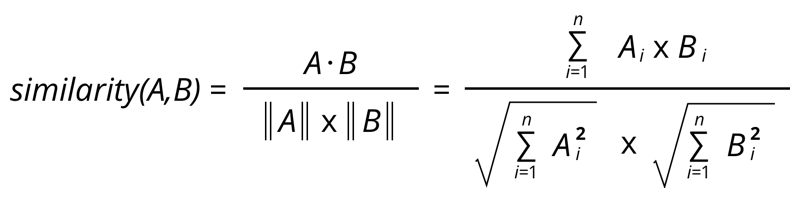

In [38]:
from numpy import dot
from numpy.linalg import norm
A = [1,2]
B = [2,2]
cos_sim = dot(A,B) / (norm(A)*norm(B))
print(cos_sim)

0.9486832980505138


In [39]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [40]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.349201,0.385178,0.364704,0.454874,0.433950,0.360516,0.364296,0.359227,0.200107,0.386401,0.391380,0.441767,0.201807,0.474305
1,0.349201,1.000000,0.397255,0.342101,0.401385,0.332386,0.344731,0.297847,0.314075,0.151947,0.362104,0.422518,0.360601,0.252675,0.451577
2,0.385178,0.397255,1.000000,0.371421,0.485203,0.377764,0.436772,0.345215,0.330261,0.178114,0.439715,0.459062,0.343535,0.340960,0.451924
3,0.364704,0.342101,0.371421,1.000000,0.474033,0.365011,0.351814,0.355117,0.263101,0.191216,0.446084,0.462441,0.353214,0.278858,0.431610
4,0.454874,0.401385,0.485203,0.474033,1.000000,0.375869,0.431487,0.352487,0.317545,0.149552,0.419997,0.483830,0.388251,0.323267,0.473288
5,0.433950,0.332386,0.377764,0.365011,0.375869,1.000000,0.313716,0.308531,0.379268,0.177796,0.361817,0.466256,0.327375,0.235445,0.463806
6,0.360516,0.344731,0.436772,0.351814,0.431487,0.313716,1.000000,0.421666,0.369966,0.178442,0.396367,0.377812,0.319558,0.251187,0.460658
7,0.364296,0.297847,0.345215,0.355117,0.352487,0.308531,0.421666,1.000000,0.335149,0.155000,0.398987,0.347073,0.282168,0.277010,0.375003
8,0.359227,0.314075,0.330261,0.263101,0.317545,0.379268,0.369966,0.335149,1.000000,0.171002,0.373841,0.334642,0.289373,0.194799,0.359737
9,0.200107,0.151947,0.178114,0.191216,0.149552,0.177796,0.178442,0.155000,0.171002,1.000000,0.175017,0.194690,0.165347,0.123582,0.275177


In [41]:
# Hàm đề xuất khách sạn
# # với mỗi  ks, lấy nums ks tương quan nhất
def get_recommendations(hotel_id, cosine_sim=cosine_sim, nums=5):
    idx = df.index[df['Hotel_ID'] == hotel_id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]
    hotel_indices = [i[0] for i in sim_scores]
    return df.iloc[hotel_indices]

In [42]:
# Gọi function
recommendations = get_recommendations('1_1')
recommendations

,Hotel_ID,Hotel_Name,Hotel_Description,Content,Content_wt
14,1_15,Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel),Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách_Sạn_Erica Nha_Trang - Sự Lựa_Chọn Hoàn_H...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách_sạn Balcony Nha_Trang - Nơi nghỉ_dưỡng t...
12,1_13,Senkotel Nha Trang do NEST Group quản lý (Senk...,Senkotel Nha Trang do NEST Group quản lý - Khá...,Senkotel Nha Trang do NEST Group quản lý - Khá...,Senkotel Nha_Trang do NEST Group quản_lý - Khá...
5,1_6,Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn_hộ Kymodo_Panorama - Nơi lưu_trú lý_tưởng ...
11,1_12,Khách sạn AZURA (Azura Hotel),Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách_sạn AZURA - Trải nghiệm thoải_mái và tiệ...


In [43]:
# Chú ý: Vì công thức tính toán của Gensim và Cosin khác nhau nên một số kết quả đề xuất cũng sẽ khác

In [44]:
# Save cosine_sim to file
import pickle
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Open and read file to cosine_sim_new
with open('cosine_sim.pkl', 'rb') as f:
    cosine_sim_new = pickle.load(f)
# cosine_sim_new

In [45]:
# Gọi function
recommendations = get_recommendations(hotel_id ='1_1', cosine_sim=cosine_sim_new, nums=5)
recommendations

,Hotel_ID,Hotel_Name,Hotel_Description,Content,Content_wt
14,1_15,Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel),Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...,Khách_Sạn_Erica Nha_Trang - Sự Lựa_Chọn Hoàn_H...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách_sạn Balcony Nha_Trang - Nơi nghỉ_dưỡng t...
12,1_13,Senkotel Nha Trang do NEST Group quản lý (Senk...,Senkotel Nha Trang do NEST Group quản lý - Khá...,Senkotel Nha Trang do NEST Group quản lý - Khá...,Senkotel Nha_Trang do NEST Group quản_lý - Khá...
5,1_6,Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...,Căn_hộ Kymodo_Panorama - Nơi lưu_trú lý_tưởng ...
11,1_12,Khách sạn AZURA (Azura Hotel),Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách sạn AZURA - Trải nghiệm thoải mái và tiệ...,Khách_sạn AZURA - Trải nghiệm thoải_mái và tiệ...
